# MACHINE LEARNING PROJECT
Jonas Neuschäfer, Lena Siemer

In this project we look at the 20 newsgroups dataset and apply various methods that we learned during the lab to achieve classification results.

We start by preprocessing the dataset. For this purpose, we remove symbols, irrelevant words and other things from the news texts.
Then we turn to vectorizing the dataset and extracting the tf-idf features. As a benchmark for a first attempt at classification, we use the RidgeClassifier and apply it to the features and check whether the options for cleaning up the dataset have an influence.
We delve a little deeper into the individual news categories and illustrate overlaps between the classes and look at the features and words that are most important for classification.
Based on this, we want to consider the questions of how good a classification is for selected similar news classes and how much better we can get if we combine similar classes into one.

Now that we have tried things out with the dataset at hand, we now want to consider the classification itself. To do this, we compare all the options considered in the lab and also set up a neural network as we have learned.

After this comparison of the different options for classification via feature extraction, we also carry out a classification via fine-tuning.


## Disclaimer
Later in the notebook, we experiment with a classification via fine-tuning (pretrained bert model). This is very slow without a GPU. Therefore, it is not recommended to run this part of the notebook without a GPU, although the following cell ensures that this is possible.

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# import required packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import string
import nltk
nltk.download('wordnet')
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import scipy as sp
import copy

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# load the dataset
news_train = fetch_20newsgroups(subset = "train", remove = ('headers', 'footers', 'quotes'),)
news_test = fetch_20newsgroups(subset = "test", remove = ('headers', 'footers', 'quotes'),)

# names of the newsgroups
target_names = news_train.target_names

# labels / targets of the newsgroups
y_train, y_test = news_train.target, news_test.target

## Preprocessing the news
In our preprocessing function, we transform each of the news into a list of words. Then we apply different ideas:
- delete symbols, punctuation
- remove numbers
- remove too small words (<=2)
- regularize the words
- delete stopwords
- function for lemmatization
- We also provide functions for n-gram and Bag-of-words feautures (but, by default, we do not use them in our standard cleaning process below, as they did not contribute to better results). You find them in the backup section in the end of the notebook

and return the cleaned news as a string again.

In [5]:
def preprocess(news_no_x):
  # remove some kind of metadata ("\n" is used for new lines, "\t" is used for tabs)
  news_no_x = news_no_x.replace("\t", " ")
  news_no_x = news_no_x.replace("\n", " ")

  # words of the news into list
  words = news_no_x[0:len(news_no_x)].strip().split(" ")

  # First, we want to delete all symbols and punctuation from our words
  # + but we keep the "'" because this would change the meaning (he'll will becom hell)
  words = [word.translate(str.maketrans('', '', (string.punctuation).replace("'", ""))) for word in words]

  # only keep them if a "valid string" survives (we had words only consisting of "'" at this stage of our process)
  words = [str for str in words if str]

  # now we try out several ideas, like removing digits, too small words (<=2), regularization (remove upper cases)
  words = [word for word in words if not (word.isdigit() or len(word) <= 2)]
  words = [word.lower() for word in words]

  # and finally remove words regarded as unnccesary
  stopwords = ['about', 'above', 'after', 'again', 'against', 'all', 'and', 'any', 'are', "aren't", 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but',
               'can', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'does', "doesn't", 'doing', "don't", 'down', 'during',
               'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', "he'd", "he'll", "he's", 'her', 'here', "here's",
               'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", "i'd", "i'll", "i'm", "i've", 'into', "isn't", "it's", 'its', 'itself',
               "let's", 'more', 'most', "mustn't", 'myself', 'nor', 'not', 'off', 'once', 'only', 'other', 'ought', 'our', 'ours' 'ourselves', 'out', 'over', 'own',
               'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'some', 'such',
               'than', 'that',"that's", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', "there's", 'these', 'they', "they'd",
               "they'll", "they're", "they've", 'this', 'those', 'through', 'too', 'under', 'until', 'very', 'was', "wasn't", "we'd", "we'll", "we're", "we've", 'were', "weren't", 'what', "what's", 'when', "when's", 'where',
               "where's", 'which', 'while', 'who', "who's", 'whom', 'why', "why's",'will', 'with', "won't", 'would', "wouldn't",
               'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves',
               'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'hundred', 'thousand', '1st', '2nd', '3rd',
               '4th', '5th', '6th', '7th', '8th', '9th', '10th']
  words = [word for word in words if not word in stopwords]

  # lemmatization (only if necessary)
  #lemmatizer = nltk.stem.WordNetLemmatizer()
  #words = [lemmatizer.lemmatize(word) for word in words]

  # afterwards we return the cleaned news
  return ' '.join(words)

Here is an example of the cleaning process:

The first news are

In [5]:
print(news_train.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


which contain

In [6]:
len(news_train.data[0][0:len(news_train.data[0]) - 1].strip().split(" "))

86

words. Those surviving the process are

In [7]:
preprocess(news_train.data[0])[0:len(preprocess(news_train.data[0]))].strip().split(" ")

['wondering',
 'anyone',
 'enlighten',
 'car',
 'saw',
 'day',
 '2door',
 'sport',
 'car',
 'looked',
 'late',
 '60',
 'early',
 '70',
 'called',
 'bricklin',
 'door',
 'really',
 'small',
 'addition',
 'front',
 'bumper',
 'separate',
 'rest',
 'body',
 'know',
 'anyone',
 'tellme',
 'model',
 'name',
 'engine',
 'spec',
 'year',
 'production',
 'car',
 'made',
 'history',
 'whatever',
 'info',
 'funky',
 'looking',
 'car',
 'please',
 'email']

only

In [8]:
len(preprocess(news_train.data[0])[0:len(preprocess(news_train.data[0]))].strip().split(" "))

44

words. Hence, we reduced the amount of words relevant for the classification process by almost 50% in this example.

In the following we want to gain more intuition by implementing a vectorizer ourself. It should use the token counts for the vectors.
For this case we need to introduce Bag of words. Bag of word models are an unordered representation of a text. We can use it to extract features.

In [9]:
def bag_of_words(text):
    bag={}
    text=text.split()
    for word in text:
        # we add each word to the dictionary and count how many words of this kind are in the text
        if word not in bag:
            bag[word]=1
        else:
            bag[word]+=1

    return bag

bag_of_words(news_train.data[0])

{'I': 3,
 'was': 4,
 'wondering': 1,
 'if': 1,
 'anyone': 2,
 'out': 1,
 'there': 1,
 'could': 1,
 'enlighten': 1,
 'me': 1,
 'on': 2,
 'this': 3,
 'car': 2,
 'saw': 1,
 'the': 5,
 'other': 1,
 'day.': 1,
 'It': 2,
 'a': 3,
 '2-door': 1,
 'sports': 1,
 'car,': 2,
 'looked': 1,
 'to': 1,
 'be': 1,
 'from': 2,
 'late': 1,
 '60s/': 1,
 'early': 1,
 '70s.': 1,
 'called': 1,
 'Bricklin.': 1,
 'The': 1,
 'doors': 1,
 'were': 1,
 'really': 1,
 'small.': 1,
 'In': 1,
 'addition,': 1,
 'front': 1,
 'bumper': 1,
 'separate': 1,
 'rest': 1,
 'of': 2,
 'body.': 1,
 'This': 1,
 'is': 2,
 'all': 1,
 'know.': 1,
 'If': 1,
 'can': 1,
 'tellme': 1,
 'model': 1,
 'name,': 1,
 'engine': 1,
 'specs,': 1,
 'years': 1,
 'production,': 1,
 'where': 1,
 'made,': 1,
 'history,': 1,
 'or': 1,
 'whatever': 1,
 'info': 1,
 'you': 1,
 'have': 1,
 'funky': 1,
 'looking': 1,
 'please': 1,
 'e-mail.': 1}

We want to use bag of words for vectorization. Our implementation is not efficient enough for the entire set, therefore we will just test it on a subset.

In [10]:
# get a subset of the categories
categories = [
    "comp.graphics",
    "alt.atheism",
    "sci.med",
    "sci.space",
]

subset_train = fetch_20newsgroups(subset="train", categories=categories, remove=('headers', 'footers', 'quotes'),)

subset_test = fetch_20newsgroups(subset="test", categories=categories,remove=('headers', 'footers', 'quotes'),)

# first we want to create an dictionary with our features
def get_features(texts):
    features={}
    i=0
    for text in texts:
        text=preprocess(text).split()
        for word in text:
            if word not in features:
                features[word]=i
                i+=1

    return features

features= get_features(subset_train.data)

features


{'subject': 0,
 'shuttle': 1,
 'software': 2,
 'ever': 3,
 'happened': 4,
 'hypothesis': 5,
 'flight': 6,
 'major': 7,
 'factor': 8,
 'loss': 9,
 '51l': 10,
 'wit': 11,
 'wind': 12,
 'shear': 13,
 'event': 14,
 'control': 15,
 'indicated': 16,
 'series': 17,
 'violent': 18,
 'engine': 19,
 'movement': 20,
 'shocked': 21,
 'set': 22,
 'upa': 23,
 'harmonic': 24,
 'resonance': 25,
 'leading': 26,
 'overstress': 27,
 'strut': 28,
 'program': 29,
 'called': 30,
 'graphic': 31,
 'workshop': 32,
 'ftp': 33,
 'wuarchive': 34,
 'file': 35,
 'msdosgraphics': 36,
 'directory': 37,
 'grfwk61tzip': 38,
 'everthing': 39,
 'need': 40,
 'girlfriend': 41,
 'pain': 42,
 'kidney': 43,
 'stone': 44,
 'say': 45,
 'medical': 46,
 'insurance': 47,
 'get': 48,
 'removed': 49,
 'question': 50,
 'way': 51,
 'treat': 52,
 'least': 53,
 'mitigate': 54,
 'effect': 55,
 'help': 56,
 'deeply': 57,
 'appreciated': 58,
 'advice': 59,
 'referral': 60,
 'literature': 61,
 'etc': 62,
 'thank': 63,
 'think': 64,
 'correc

In [11]:
# now we try to vectorize our articles
def get_vectors(texts,features):
    vectors=[]
    new_vector=np.zeros(len(features))
    for text in texts:
        text=preprocess(text).split()
        # copy the new_vector, on the subsset it saves about 0.1s of time to not create the vector every iteration
        vector=copy.deepcopy(new_vector)
        # count the words
        for word in text:
            if word in features:
                vector[features[word]]+=1

        #Our vector has a lot of zeros. So we append a sparse row matrix
        vectors.append(sp.sparse.csr_matrix(vector))

    #stack spars arrays row wise
    return sp.sparse.vstack(vectors)

#print(len(features))

X_subset_train=get_vectors(subset_train.data,features)
X_subset_test=get_vectors(subset_test.data,features)

In [12]:
print(X_subset_train)

  (0, 0)	1.0
  (0, 1)	2.0
  (0, 2)	3.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 5)	1.0
  (0, 6)	2.0
  (0, 7)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (0, 10)	1.0
  (0, 11)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 14)	1.0
  (0, 15)	1.0
  (0, 16)	1.0
  (0, 17)	1.0
  (0, 18)	1.0
  (0, 19)	1.0
  (0, 20)	1.0
  (0, 21)	1.0
  (0, 22)	1.0
  (0, 23)	1.0
  (0, 24)	1.0
  :	:
  (2250, 682)	1.0
  (2250, 707)	1.0
  (2250, 1024)	1.0
  (2250, 1135)	1.0
  (2250, 1355)	1.0
  (2250, 1426)	1.0
  (2250, 1585)	1.0
  (2250, 1759)	1.0
  (2250, 1955)	1.0
  (2250, 2537)	1.0
  (2250, 2724)	1.0
  (2250, 3038)	1.0
  (2250, 3559)	1.0
  (2250, 3939)	1.0
  (2250, 4192)	1.0
  (2250, 4751)	1.0
  (2250, 4781)	1.0
  (2250, 4918)	3.0
  (2250, 4926)	2.0
  (2250, 8056)	1.0
  (2250, 8254)	1.0
  (2250, 10036)	1.0
  (2250, 13407)	1.0
  (2250, 23763)	1.0
  (2250, 28562)	1.0


Now we want to train our classifier and compute the accuracy. We use the Ridgeclassifier from sklearn.

In [13]:
# regression
clf = RidgeClassifier(tol = 1e-4, solver = "sparse_cg")
clf.fit(X_subset_train, subset_train.target)
pred = clf.predict(X_subset_test)
print(classification_report(subset_test.target, pred, target_names = subset_train.target_names))

               precision    recall  f1-score   support

  alt.atheism       0.62      0.56      0.59       319
comp.graphics       0.57      0.72      0.64       389
      sci.med       0.69      0.57      0.63       396
    sci.space       0.58      0.58      0.58       394

     accuracy                           0.61      1498
    macro avg       0.62      0.61      0.61      1498
 weighted avg       0.62      0.61      0.61      1498



To evaluate our implementation, we compare it to the CountVectorizer from sklearn and train the Ridgeclassifier with those vectors. The CountVectorizer also a matrix of the token counts.

In [14]:
vectorizer = CountVectorizer(stop_words='english')

vectors = vectorizer.fit_transform(subset_train.data)
test_vectors = vectorizer.transform(subset_test.data)

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(vectors, subset_train.target)


pred = clf.predict(test_vectors)


print(classification_report(subset_test.target, pred, target_names = subset_train.target_names))



               precision    recall  f1-score   support

  alt.atheism       0.63      0.55      0.59       319
comp.graphics       0.58      0.73      0.65       389
      sci.med       0.70      0.57      0.63       396
    sci.space       0.57      0.58      0.57       394

     accuracy                           0.61      1498
    macro avg       0.62      0.61      0.61      1498
 weighted avg       0.62      0.61      0.61      1498



As we can see our own implementation reaches the same accuracy as the the vectorizer from sklearn. But especially for big data this implementation is not efficient enough. But it gives a good intuition of how a vectorizer works.

## Vectorizing (different parameters)
The sklearn library offers different options for feature extraction from texts. The obvious one would be CountVectorizer. CountVectorizer counts the tokens of the text, but ignores the importance of a token. For example the word 'computer' is most likely to appear in text with tecnical context, while the word 'people' can appear in various contexts. Therefore if we see the word 'computer' we can draw a bigger conclusion about the topic than if we see 'people'.

The TfidfVectorizer adjusts the features by taking into account that some words appear more frequently than others. Our vectors are in the so called tf-idf representation.

In [15]:
# We start with the unchanged (no stopword-filtering etc) dataset

# features from the training data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(news_train.data)

# features from the test data
X_test = vectorizer.transform(news_test.data)

To get a first intuition of how to predict a certain newsgroup, we perform a classification using Ridge-regression, which is prominent for multi-class classification tasks. Later, we also set up a Neural Network for classification and compare different classifiers we have dealt with througout the lab. But just for the purpose of comparing a few preprocessing options, we use Ridge-Regression as benchmark (also because our later comparison will reveal advantegous traning time measured at its accuracy).

In [16]:
# regression
clf = RidgeClassifier(tol = 1e-2, solver = "sparse_cg")
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test), target_names = target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.53      0.48      0.50       319
           comp.graphics       0.66      0.72      0.69       389
 comp.os.ms-windows.misc       0.64      0.63      0.63       394
comp.sys.ibm.pc.hardware       0.66      0.67      0.67       392
   comp.sys.mac.hardware       0.76      0.71      0.73       385
          comp.windows.x       0.81      0.70      0.75       395
            misc.forsale       0.75      0.81      0.78       390
               rec.autos       0.78      0.70      0.74       396
         rec.motorcycles       0.79      0.77      0.78       398
      rec.sport.baseball       0.55      0.85      0.66       397
        rec.sport.hockey       0.87      0.88      0.87       399
               sci.crypt       0.85      0.72      0.78       396
         sci.electronics       0.62      0.60      0.61       393
                 sci.med       0.80      0.78      0.79       396
         

### Interpretation:
We obtain an accuracy of 70%, but observe a very high discrepancy between the different newsgroups, as can be seen from the precision score (predicted positive actually being positive $\frac{TP_{class}}{TP_{class} + FP_{class}}$) and the recall score (For each class, measures the models ability to find the positive cases $\frac{TP_{class}}{TP_{class} + FN_{class}}$). The f1-score is the harmonic mean of the both preceding ones and we will use it later in our fine-tuning model.

We go ahead using some preprocessing options of the vectorizer, i.e. we filter stopwords and also try n-gram to find out whether this influences the accuracy of our predictions. We start with giving stopwords and n_gram as options. We use our own written function to preprocess the data later in the notebok.

In [17]:
# now vectorizing with given stopwords, and also ngram
vectorizer = TfidfVectorizer(stop_words = "english", ngram_range = (1, 2))
X_train = vectorizer.fit_transform(news_train.data)
X_test = vectorizer.transform(news_test.data)

#regression
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test), target_names = target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.53      0.45      0.49       319
           comp.graphics       0.67      0.72      0.69       389
 comp.os.ms-windows.misc       0.65      0.65      0.65       394
comp.sys.ibm.pc.hardware       0.68      0.68      0.68       392
   comp.sys.mac.hardware       0.74      0.71      0.72       385
          comp.windows.x       0.83      0.71      0.76       395
            misc.forsale       0.73      0.80      0.76       390
               rec.autos       0.80      0.71      0.75       396
         rec.motorcycles       0.83      0.76      0.80       398
      rec.sport.baseball       0.54      0.85      0.66       397
        rec.sport.hockey       0.88      0.90      0.89       399
               sci.crypt       0.85      0.71      0.77       396
         sci.electronics       0.64      0.60      0.62       393
                 sci.med       0.79      0.80      0.80       396
         

In [18]:
# only stopwords as preprocessing and feature extraction
vectorizer = TfidfVectorizer(stop_words = "english")
X_train = vectorizer.fit_transform(news_train.data)
X_test = vectorizer.transform(news_test.data)

#regression
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred, target_names = target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.54      0.48      0.51       319
           comp.graphics       0.69      0.74      0.71       389
 comp.os.ms-windows.misc       0.64      0.64      0.64       394
comp.sys.ibm.pc.hardware       0.65      0.67      0.66       392
   comp.sys.mac.hardware       0.73      0.71      0.72       385
          comp.windows.x       0.83      0.69      0.75       395
            misc.forsale       0.73      0.78      0.75       390
               rec.autos       0.51      0.78      0.61       396
         rec.motorcycles       0.79      0.77      0.78       398
      rec.sport.baseball       0.84      0.80      0.82       397
        rec.sport.hockey       0.87      0.88      0.87       399
               sci.crypt       0.85      0.71      0.77       396
         sci.electronics       0.61      0.59      0.60       393
                 sci.med       0.80      0.77      0.78       396
         

At the moment, both options do not really lead to a significant improvement.

### Confusion Matrix
We plot the confusion matrix to visualize the low f1-score of several classes.

Text(0.5, 1.0, 'Confusion Matrix')

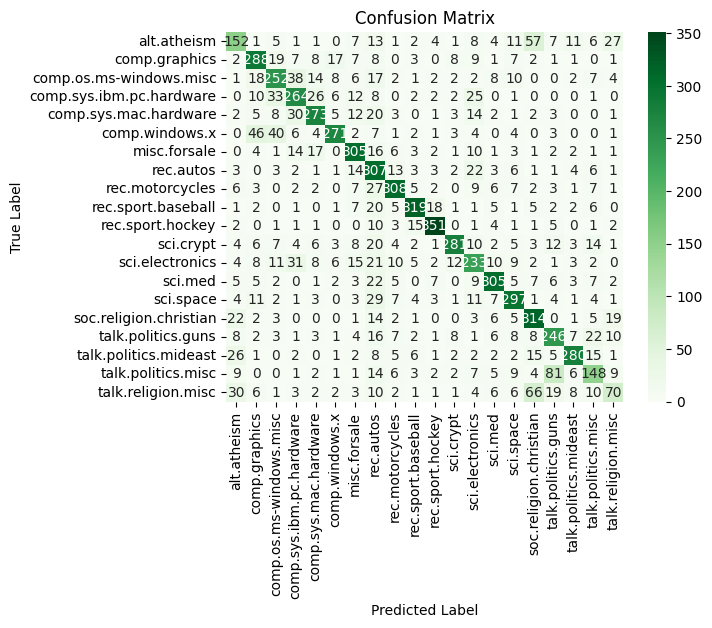

In [19]:
sns.heatmap(confusion_matrix(y_test, pred), cmap = "Greens", annot = True, fmt = "d", xticklabels = target_names, yticklabels = target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title("Confusion Matrix")

We see a lot of intersections between the newsgroups, which is of course not against expectations. Obviously, several words in the range of talk.politics.misc can be associated with another group in that area, like talk.politics.guns for example (but not vice-versa in that case), or comp.windows shares expressions with those of comp.graphics.

Here, we will have a closer look on how certain words impact the assignment to one of the newsgroups.

What are the words with the highest TF-IDF scores?

In [20]:
vectorizer.get_feature_names_out().shape

(101322,)

The function vectorizer.get_feature_names_out() yields 101322 features the vectorizer considers.

Words with the highest TF-IDF scores:

In [21]:
# We need X_train as array because it is not hashable
X_train = X_train.toarray()

# Sum the TF-IDF scores for each feature
# first we fetch all features
feature_names = vectorizer.get_feature_names_out()
# np.sum(X_train, axis=0) is the sum of scores for each of those features, so we sort them accordingly (reverse, i.e. [::-1])
tfidf_sorting = np.argsort(np.sum(X_train, axis=0))[::-1]

# Get the top 50 features
top_features = np.array(feature_names)[tfidf_sorting][:50]

print("Top features and their TF-IDF scores:")
for feature in top_features:
    feature_index = vectorizer.vocabulary_.get(feature)
    print(f"{feature}: {np.sum(X_train[:, feature_index])}")

Top features and their TF-IDF scores:
just: 145.76703311748804
like: 145.47400981208466
know: 142.87342840213665
don: 141.30102276982188
people: 127.82810521949798
think: 121.2483178536161
does: 121.18492244006889
use: 106.67579862431762
thanks: 103.77928595864768
good: 102.5957642653628
time: 99.5446023305411
new: 91.4841427856868
ve: 87.08595921881543
god: 82.21213214607913
need: 79.06002524062356
make: 78.83423177387375
edu: 78.39390793417856
way: 78.27067333520937
want: 76.85154881460687
right: 76.12915551200787
windows: 76.08188867838965
problem: 75.56807666915381
did: 75.49449287550266
say: 74.36940793421488
used: 72.17276380074902
really: 70.29329941871877
drive: 66.43674178729248
work: 66.23093701517479
mail: 63.98092544873669
believe: 62.86859231581584
ll: 62.67830335324517
got: 62.160250690002584
using: 61.40696025480746
year: 61.31494126671686
help: 60.54518841710312
said: 60.439584584104956
sure: 60.16323230065703
going: 59.41040631972887
years: 55.99464768119111
card: 55.8

Well, this is not very helpful. We should rather look at them per newsgroup:

In [22]:
for i, news_class in enumerate(target_names):
  coefficients = clf.coef_[i]
  # indices = np.argsort(coefficients)[-10:]
  top_words = [(feature_names[x], coefficients[x]) for x in (np.argsort(coefficients)[-10:])]
  print(f"Top words for class {news_class}:")
  for word, coef in top_words:
      print(f"{word}: {coef}")
  print("")

Top words for class alt.atheism:
species: 1.3137615863930912
atheists: 1.3191507887767695
cruel: 1.352890825866781
religion: 1.4143846701554887
islamic: 1.4920675577645743
deletion: 1.5592586228493712
islam: 1.5637846578699846
bobby: 1.584062727177106
motto: 1.9078508917198038
atheism: 2.027824466338474

Top words for class comp.graphics:
3do: 1.5656946662701898
animation: 1.57557665589159
68070: 1.650997281976993
images: 1.661241031570467
cview: 1.6688968194842935
tiff: 1.7061823417932676
pov: 1.7901283582878251
image: 1.8842510091043836
3d: 2.1399331837623143
graphics: 2.731000991210578

Top words for class comp.os.ms-windows.misc:
smartdrv: 1.1046793467877303
download: 1.1162295904812702
mfc: 1.1978740427493013
w4wg: 1.308683205142943
ini: 1.4340793924948745
risc: 1.5611843699972645
ax: 1.6795387876577776
win3: 1.7242509893300104
cica: 2.183523823958784
windows: 3.1095975500522846

Top words for class comp.sys.ibm.pc.hardware:
ide: 1.3059316231132976
t560i: 1.3061462736901428
orchid

Here, one sees the features which indicates strongest for every newsgroup and the corresponding positive coefficient of it.

We could also run some sample checks if we find something questionable ("loser" was for example associated with talk.pol.mideast)

In [23]:
for x in news_train.data:
    if 'loser' in x:
        print(x)
        break

Excuse me, but if you really new what the show was about, you'd know that he
doesn't just say vagina and penis and that is how he get's his ratings. He
also addresss real issues as well as being outrageous. I don't hear any of these
other idiots doing a funny show and getting into some serious topics at the
same time, he get's people to think and entertains them at the same time, 
so try listening to his show a little closer before you tell them that they are
WRONG, and by the way, if he is such a flash in the pan, why do his ratings sustain
so well? Hmm?




-- 
-----------------------------------------------
Greg W. Lazar             greg@puck.webo.dg.com

J-E-T-S JETS JETS JETS


but apart from controlling for single words (from which we abstained at this point because some experiments were not very promising), two other questions, which are very simple to tackle, arise:

1. Can we we improve the accuracy of our classification if we group news from similar categories together?
2. What do we get if we want our classifiers to learn to predict the newsgroup for similar news (similar in the sense of similar categories)?

## Grouping

In [24]:
# We start with grouping similar news_categories together
target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [25]:
# That is how we assign those categories to broader sets
target_names = ['alt.atheism', 'computer', 'misc', 'recreation', 'science', 'religion', 'talk']
dictnary = {0:0,
              1:1,
              2:1,
              3:1,
              4:1,
              5:1,
              6:2,
              7:3,
              8:3,
              9:3,
              10:3,
              11:4,
              12:4,
              13:4,
              14:4,
              15:5,
              16:6,
              17:6,
              18:6,
              19:6}
target_names

['alt.atheism',
 'computer',
 'misc',
 'recreation',
 'science',
 'religion',
 'talk']

The initial categories of the first 20 news were

In [26]:
y_train[:20]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4,  8, 19,  4, 14,  6,  0,  1,
        7, 12,  5])

and now, after applying our dictionary, they are categorized in the supersets:

In [27]:
y_train = np.vectorize(dictnary.get)(y_train)
y_test = np.vectorize(dictnary.get)(y_test)
y_train[:20]

array([3, 1, 1, 1, 4, 6, 4, 1, 1, 1, 3, 6, 1, 4, 2, 0, 1, 3, 4, 1])

In [28]:
# preprocessing and classification
vectorizer = TfidfVectorizer(stop_words = "english")
X_train = vectorizer.fit_transform(news_train.data)
X_test = vectorizer.transform(news_test.data)

# regression
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred, target_names = target_names))

              precision    recall  f1-score   support

 alt.atheism       0.64      0.36      0.46       319
    computer       0.84      0.89      0.86      1955
        misc       0.88      0.69      0.77       390
  recreation       0.77      0.89      0.83      1590
     science       0.78      0.72      0.75      1579
    religion       0.73      0.67      0.70       398
        talk       0.76      0.76      0.76      1301

    accuracy                           0.79      7532
   macro avg       0.77      0.71      0.73      7532
weighted avg       0.79      0.79      0.78      7532



At least, as expected, we achieve an accuracy of 79%.

Text(0.5, 1.0, 'Confusion Matrix')

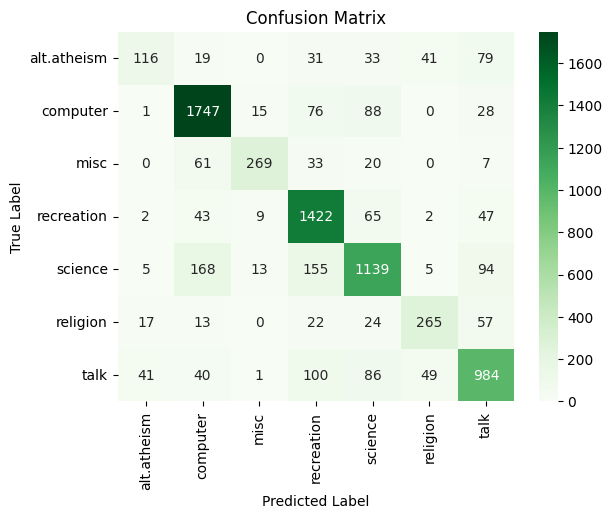

In [29]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, pred), cmap = "Greens", annot = True, fmt = "d", xticklabels = target_names, yticklabels = target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title("Confusion Matrix")

and now we have some overlappings between the broad categories "computer" and "science".

## Similar categories

In [30]:
# load dataset - fetch only some categories which seem to have similar topics or
# where we observed a higher amount of misclassified news in our confusion matrix
# from the beginning
news_train = fetch_20newsgroups(subset = "train",
        categories = ['talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc'],
        remove = ('headers', 'footers', 'quotes'),)

news_test = fetch_20newsgroups(subset = "test",
        categories = ['talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc'],
        remove = ('headers', 'footers', 'quotes'),)

# names of the newsgroups
target_names = news_train.target_names

# labels / targets of the newsgroups
y_train, y_test = news_train.target, news_test.target

In [31]:
news_train.target[:20]

array([3, 0, 1, 3, 3, 1, 3, 1, 2, 3, 1, 1, 2, 2, 0, 2, 1, 3, 0, 0])

                       precision    recall  f1-score   support

   talk.politics.guns       0.64      0.75      0.69       364
talk.politics.mideast       0.80      0.86      0.83       376
   talk.politics.misc       0.65      0.53      0.59       310
   talk.religion.misc       0.77      0.69      0.73       251

             accuracy                           0.72      1301
            macro avg       0.72      0.71      0.71      1301
         weighted avg       0.72      0.72      0.71      1301



Text(0.5, 1.0, 'Confusion Matrix')

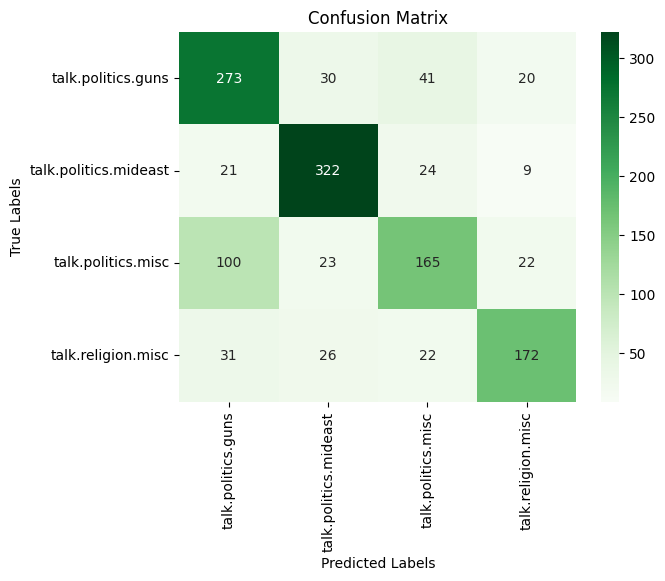

In [32]:
# extracting features
vectorizer = TfidfVectorizer(stop_words = "english")
X_train = vectorizer.fit_transform(news_train.data)
X_test = vectorizer.transform(news_test.data)

# regression
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred, target_names = target_names))

sns.heatmap(confusion_matrix(y_test, pred), cmap = "Greens", annot = True, fmt = "d", xticklabels = target_names, yticklabels = target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title("Confusion Matrix")

# Neural Network
So far, we tried out several options and questions regarding the dataset to evaluate the predictions we get. Now, we return to our complete dataset of news, and we want to delve deeper into the comparison of different classifiers.

For this purpose, we set up a Neural Network, and then we write a function that will compare many classifiers we introduced during the lab.

In [33]:
# reload the complete dataset
from sklearn.datasets import fetch_20newsgroups
news_train = fetch_20newsgroups(subset = "train", remove = ('headers', 'footers', 'quotes'),)
news_test = fetch_20newsgroups(subset = "test", remove = ('headers', 'footers', 'quotes'),)

# names of the newsgroups
target_names = news_train.target_names

# labels / targets of the newsgroups
y_train, y_test = news_train.target, news_test.target

In [34]:
# vectorize the dataset and acquain the features
vectorizer = TfidfVectorizer(stop_words = "english")
X_train = vectorizer.fit_transform(news_train.data).toarray()
X_test = vectorizer.transform(news_test.data).toarray()

In [35]:
# from exercise sheet 4 about "Deep Learning", we import (copied) the function to evaluate the fitting process
def plot_history(history):
    x = range(history.params['epochs'])
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].set_title('accuracy')
    axarr[0].plot(x, acc, label='train')
    axarr[0].plot(x, val_acc, label='validation')
    axarr[0].legend()

    loss, val_loss = history.history['loss'], history.history['val_loss']
    axarr[1].set_title('loss')
    axarr[1].plot(x, loss, label='train')
    axarr[1].plot(x, val_loss, label='validation')
    axarr[1].legend()

For initialising the Neural Network, we applied the ideas we have learned in connection with exercise sheet 4 about Deep Learning)

Attention: With the full dataset and the current initialized settings of the following Neural Network, a relatively high amount of RAM is required.

In [36]:
# Neural Network
num_classes = len(target_names)

#one-hot encodeing, vector which has integers that represent different categories can be converted into a numpy array (or) a matrix which has binary values
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)

nn = Sequential()
nn.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu')) # input layers with relu, as we already know, as activation function
nn.add(Dropout(0.5)) # dropout
nn.add(Dense(256, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(num_classes, activation='softmax')) # softmax activation function

nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # we use the adam optimizer

Epoch 1/5
89/89 [==============================] - 13s 115ms/step - loss: 2.4666 - accuracy: 0.3756 - val_loss: 1.4873 - val_accuracy: 0.6608
Epoch 2/5
89/89 [==============================] - 3s 30ms/step - loss: 0.8910 - accuracy: 0.7755 - val_loss: 1.0261 - val_accuracy: 0.7055
Epoch 3/5
89/89 [==============================] - 3s 28ms/step - loss: 0.3559 - accuracy: 0.9154 - val_loss: 1.0098 - val_accuracy: 0.7079
Epoch 4/5
89/89 [==============================] - 3s 29ms/step - loss: 0.1955 - accuracy: 0.9554 - val_loss: 1.0414 - val_accuracy: 0.7078
Epoch 5/5
89/89 [==============================] - 3s 28ms/step - loss: 0.1406 - accuracy: 0.9660 - val_loss: 1.0857 - val_accuracy: 0.7066


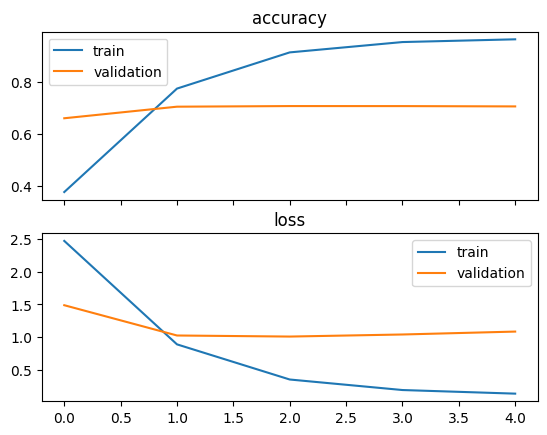

In [37]:
plot_history(nn.fit(X_train, y_train_one_hot, epochs = 5, batch_size = 128, validation_data = (X_test, y_test_one_hot)))

It seems we are already overfitting quickly (this conclusion aroused from several runs of the above cell with different parameters).

236/236 [==============================] - 1s 4ms/step
                          precision    recall  f1-score   support

             alt.atheism       0.54      0.55      0.54       319
           comp.graphics       0.69      0.73      0.71       389
 comp.os.ms-windows.misc       0.62      0.60      0.61       394
comp.sys.ibm.pc.hardware       0.60      0.70      0.64       392
   comp.sys.mac.hardware       0.76      0.72      0.74       385
          comp.windows.x       0.86      0.70      0.77       395
            misc.forsale       0.77      0.74      0.75       390
               rec.autos       0.78      0.73      0.75       396
         rec.motorcycles       0.81      0.73      0.77       398
      rec.sport.baseball       0.58      0.89      0.70       397
        rec.sport.hockey       0.88      0.90      0.89       399
               sci.crypt       0.79      0.76      0.77       396
         sci.electronics       0.65      0.62      0.64       393
                 sci

Text(0.5, 1.0, 'Confusion Matrix')

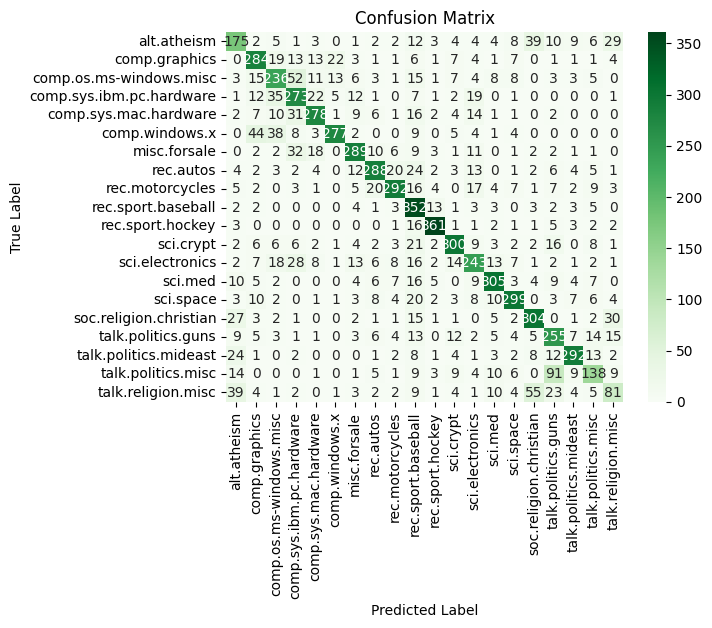

In [38]:
pred = np.argmax(nn.predict(X_test), axis = 1)
print(classification_report(y_test, pred, target_names = target_names))
sns.heatmap(confusion_matrix(y_test, pred), cmap = "Greens", annot = True, fmt = "d", xticklabels = target_names, yticklabels = target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title("Confusion Matrix")

# Comparison of different Classifiers

In [39]:
# Define function to train and evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    t0 = time()
    model.fit(X_train, y_train)
    train_time = time() - t0
    print(f'time: {train_time}')
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print(f'accuracy: {accuracy}')
    cm = confusion_matrix(y_test, pred)
    return accuracy, cm, train_time

Neural Network
Epoch 1/3
89/89 [==============================] - 9s 107ms/step - loss: 0.1212 - accuracy: 0.9692 - val_loss: 1.1174 - val_accuracy: 0.7047
Epoch 2/3
89/89 [==============================] - 3s 29ms/step - loss: 0.1108 - accuracy: 0.9703 - val_loss: 1.1451 - val_accuracy: 0.7057
Epoch 3/3
89/89 [==============================] - 2s 28ms/step - loss: 0.1080 - accuracy: 0.9714 - val_loss: 1.1711 - val_accuracy: 0.7033
time: 24.02781391143799
236/236 [==============================] - 1s 4ms/step
accuracy: 0.7032660647902284
Multinomial Bayes
time: 0.08361029624938965
accuracy: 0.6779075942644716
Support Vector Machine
time: 2.7678518295288086
accuracy: 0.6955655868295274
Random Forest
time: 61.50780701637268
accuracy: 0.6242697822623473
Logistic
time: 65.80030274391174
accuracy: 0.6931757833244823
Ridge
time: 3.966111898422241
accuracy: 0.6988847583643123
Nearest Neighbors
time: 0.004343748092651367
accuracy: 0.05496548061603824


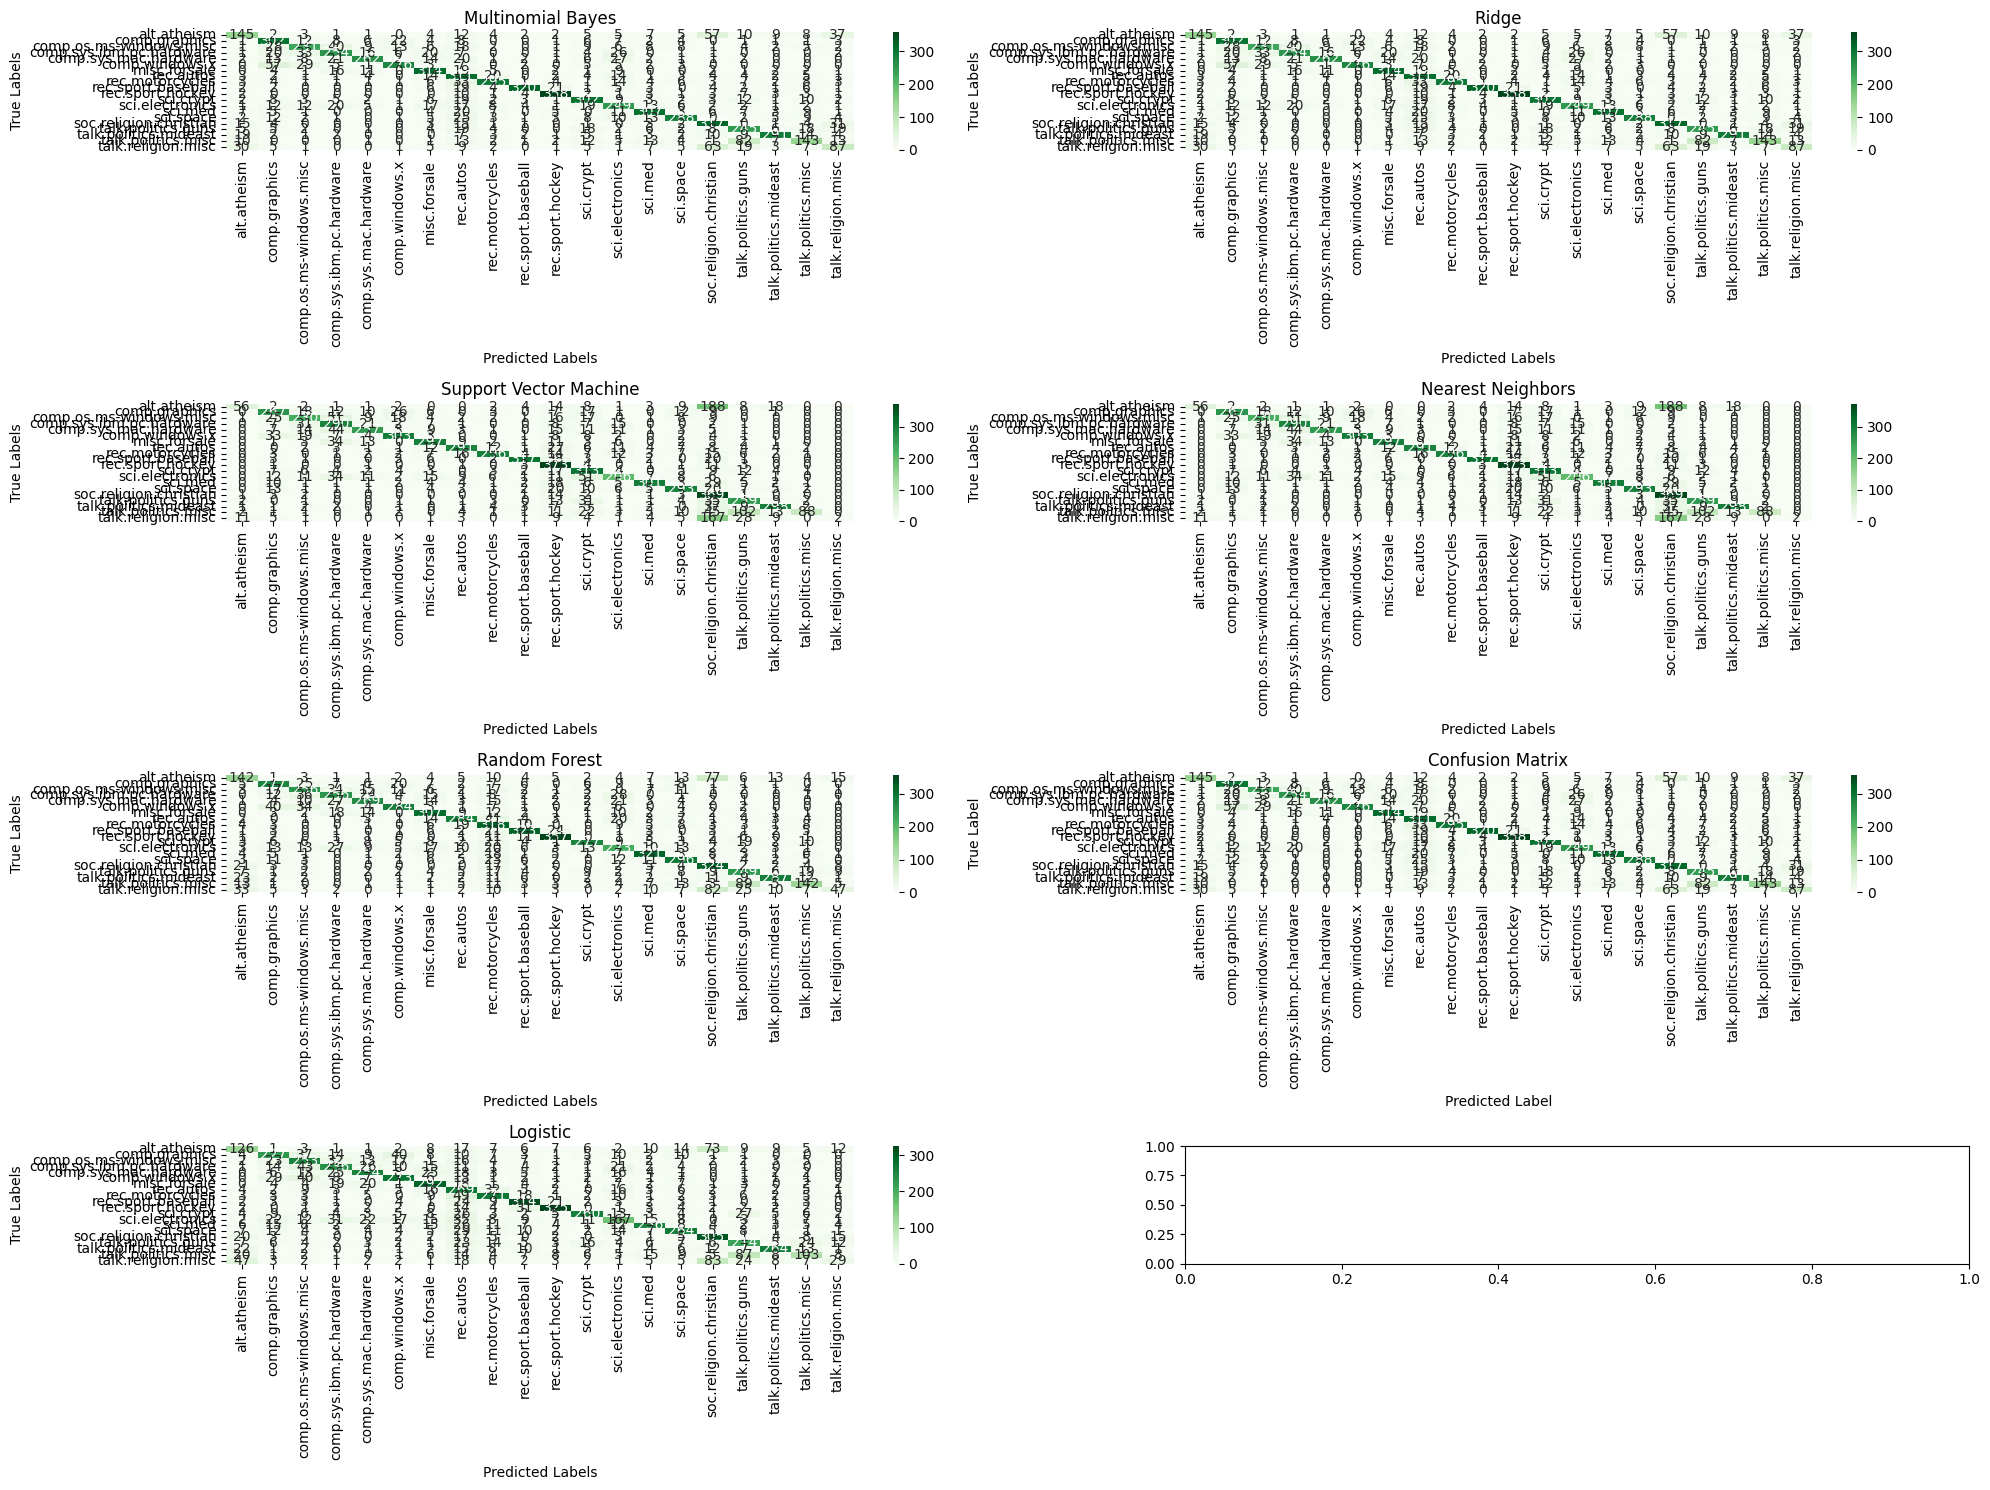

In [40]:
help_list = []
help_list_names = []
fig, axes = plt.subplots(4, 2, figsize=(20, 15))

# add our Neural Network (here we use just 3 epochs, again very high RAM usage for the whole model)
name = "Neural Network"
help_list_names.append(name)
print(name)
t0 = time()
nn.fit(X_train, y_train_one_hot, epochs = 3, batch_size = 128, validation_data = (X_test, y_test_one_hot))
train_time = time() - t0
print(f'time: {train_time}')
pred = np.argmax(nn.predict(X_test), axis = 1)
accuracy = accuracy_score(y_test, pred)
print(f'accuracy: {accuracy}')
# just for completeness we also plot the confusion matrices, but the presentation of it will be very confusing, but we do not deal with them anyway
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, cmap = "Greens", annot = True, fmt = "d", xticklabels = target_names, yticklabels = target_names, ax = axes[2, 1])
axes[2, 1].set_xlabel('Predicted Label')
axes[2, 1].set_ylabel('True Label')
axes[2, 1].set_title("Confusion Matrix")
help_list.append((accuracy, cm, train_time))

# add several other classifiers we have dealt with in class

# beforehand again vectorize the dataset and acquain the features now avoiding the function .toarray() as for the Neural Network -- this will reduce cumputation time dastically
vectorizer = TfidfVectorizer(stop_words = "english")
X_train = vectorizer.fit_transform(news_train.data)
X_test = vectorizer.transform(news_test.data)

# other classifiers

for i, model in enumerate([('Multinomial Bayes', MultinomialNB()), ('Support Vector Machine', LinearSVC(C=0.1, dual=False, max_iter=1000)),
                          ("Random Forest", RandomForestClassifier()), ("Logistic", LogisticRegression(C=5, max_iter=1000))]):
                          print("=" * 80)
                          help_list_names.append(model[0])
                          print(model[0])
                          help_list.append( evaluate_model(model[1], X_train, y_train, X_test, y_test))
                          # just for completeness we also plot the confusion matrices, but the presentation of it will be very confusing, but we do not deal with them anyway
                          sns.heatmap(help_list[i][1], annot = True, fmt = 'd', cmap = 'Greens', xticklabels = target_names, yticklabels = target_names, ax = axes[i, 0])
                          axes[i, 0].set_title(model[0])
                          axes[i, 0].set_xlabel('Predicted Labels')
                          axes[i, 0].set_ylabel('True Labels')
for i, model in enumerate([("Ridge", RidgeClassifier(alpha=1.0, solver="sparse_cg")),
                          ("Nearest Neighbors", KNeighborsClassifier(n_neighbors=100))]):
                          print("=" * 80)
                          help_list_names.append(model[0])
                          print(model[0])
                          help_list.append(evaluate_model(model[1], X_train, y_train, X_test, y_test))
                          # just for completeness we also plot the confusion matrices, but the presentation of it will be very confusing, but we do not deal with them anyway
                          sns.heatmap(help_list[i][1], annot = True, fmt='d', cmap='Greens', xticklabels=target_names, yticklabels=target_names, ax = axes[i, 1])
                          axes[i, 1].set_title(model[0])
                          axes[i, 1].set_xlabel('Predicted Labels')
                          axes[i, 1].set_ylabel('True Labels')

plt.tight_layout()

Our Neural Network performs quite well compared to the other classifiers in terms of accuracy (71%), but of course needs a long time to train.

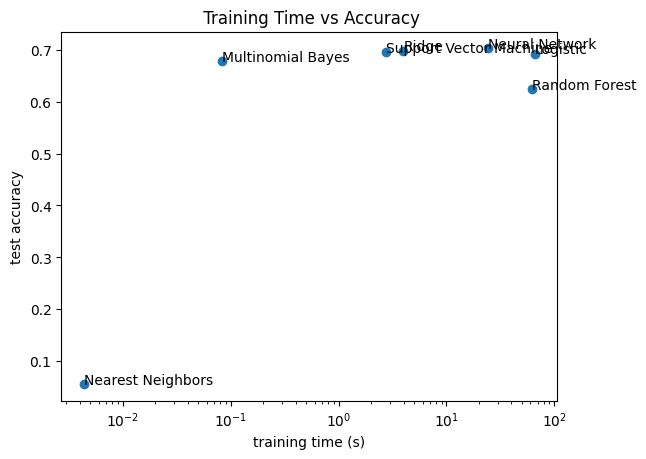

In [41]:
scores = [help_list[i][0] for i in range(len(help_list))]
time = [help_list[i][2] for i in range(len(help_list))]

plt.scatter(time, scores)
plt.title(" Training Time vs Accuracy")
plt.xscale("log")
plt.ylabel("test accuracy")
plt.xlabel("training time (s)")

for i, txt in enumerate(help_list_names):
    plt.annotate(txt, (time[i], scores[i]))

Hence, choosing Ridge-Classification in the beginning of the notebook was justified, as it has a lower trade-off between accuracy and training time.

# Working with Transformes
In the following, we want to experimentally work with (pretrained) language models which are based on transformer architecture because they have led to many recent developements in the field of natural language processing, and we want to find out, whether we can also make use of them in simple tasks from above when classifying (a certain subset of news).

Therefore, we will experiment with a distilled version of the BERT (Bidirectional Encoder Representations from Transformers) base model.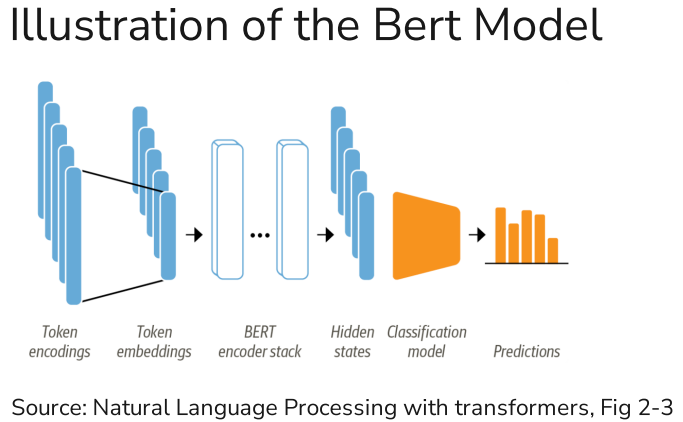

# Classification via Fine-Tuning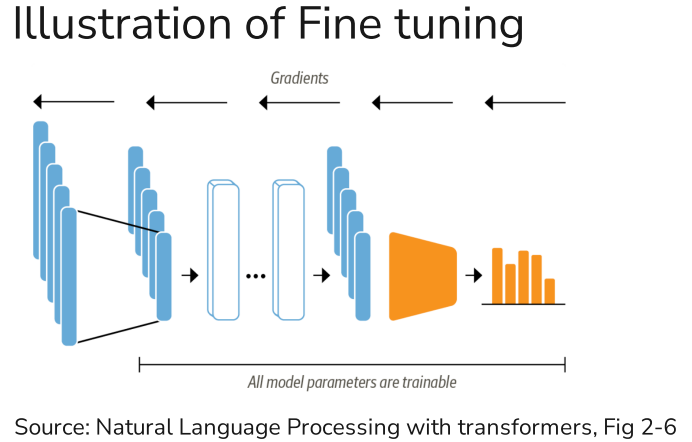
- trains all parameters
- Last hidden states are optimized to contain relevant information
- Classifier is a differentiable Neural Network
- Very slow without GPU

### Steps for fine-tuning
1. Tokenize the dataset
2. Instantiate a pre-trained model with classification head
3. (Put the model on the GPU)
4. we write a function to calculate metrics
5. Specify `TrainingArguments`
6. Instantiate a `Trainer` an train the model

In [6]:
# install / import required packages for this purpose
! pip install datasets
! pip install -U accelerate
! pip install -U transformers

from transformers import AutoTokenizer, logging, AutoModelForSequenceClassification, TrainingArguments, Trainer
import datasets as ds

logging.set_verbosity_error()

  Using cached accelerate-0.32.1-py3-none-any.whl (314 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (9

We are loading the following 4 newsgroups. Some of them share characteristcs (as found out in our simpler regression) some do not.

In [7]:
target_names[:4]

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware']

In [8]:
# load data
news_train = fetch_20newsgroups(subset = "train",categories = target_names[:4], remove = ('headers', 'footers', 'quotes'))
news_test = fetch_20newsgroups(subset = "test", categories = target_names[:4], remove = ('headers', 'footers', 'quotes'))

# labels / targets of the newsgroups
y_train, y_test = news_train.target, news_test.target

Now we make extensive use of our own written preprocessing function from the beginning.

In [9]:
# show the cleaned news in pandas.DataFrame
pandas_train = pd.DataFrame(data = [preprocess(i) for i in news_train['data']], columns=['text'])
pandas_train['label'] = news_train['target']
pandas_test = pd.DataFrame(data = [preprocess(i) for i in news_test['data']], columns=['text'])
pandas_test['label'] = news_test['target']
pandas_train

,text,label
0,trying help friend mine get second serial port...,3
1,looking window driver cornerstone dualpage cor...,2
2,anyone maintaining list favorite shareware pub...,2
3,talking majority people support anyway think r...,0
4,sigkids call participation sigkids research sh...,1
...,...,...
2240,question guido possible use esdi drive master ...,3
2241,kmr4pocwruedu keith ryan kmr41426733987668pocw...,0
2242,closer might imagine certainly despised living...,0
2243,think ideal solution use tracing utility remem...,1


In [10]:
# convert our data (currently stored in a pandas DataFrame - see cell above)
# to class Dataset (because we want to apply a BATCHED function to the whole
# dataset which can be done with the Dataset.map function)
dd = ds.DatasetDict({"train":ds.Dataset.from_pandas(pandas_train),"test":ds.Dataset.from_pandas(pandas_test)})
dd

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2245
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1494
    })
})

### Tokenization (convert text to integers)
We load a distilbert-base-uncased model for sequence classification that can be fine-tuned and put it on the GPU.

In [11]:
# Let's tokenize (convert the words or characters to integers) our data
# in our case we use a mix of both - a subword-tokenization
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
  return tokenizer(batch["text"], padding='max_length', truncation=True, max_length = 512)

# here we apply our tokenize function to the data which creates two additional
# columns in our dataset (see below) - input_ids and attention_mask
# Input ids are the unique identifiers of the tokens in a sentence. attention
# mask is used to batch the input sequence together and indicate whether the
# token should be attended by our model or not.
ds_encoded = dd.map(tokenize, batched = True, batch_size = None)
# we have to make sure that we put in on the GPU
ds_encoded.set_format("torch", columns = ["input_ids", "attention_mask", "label"])
ds_encoded.set_format("torch")
ds_encoded

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2245 [00:00<?, ? examples/s]

Map:   0%|          | 0/1494 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2245
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1494
    })
})

In [12]:
# We use the AutoModelForSequenceClassification with 4 classes
num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels = num_labels
).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

As metrics for evaluation during the training process, which will be defined in the following, we calclulate for given predictions the f1-score we already know and the accuracy score.

In [13]:
def compute_metrics(pred):
    logits, labels = pred
    preds = logits.argmax(axis = -1)
    f1 = f1_score(labels, preds, average = "weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

The function we just defined is used to select the best model after fine-tuning and to monitor the optimization. This function will be passed to the trainer and called internally.

- `labels` are y_test, i.e. a vector of correct labels
- `logits` are an array of scores of
shape (batch_size, n_choices)
- `argmax` converts `logits` to `y_pred`

### Specifying arguments for training
- select the adam implementation
from pytorch
- we train for only 2 epochs with batch size
64
- Select model with best f1 score at
the end

In [14]:
batch_size = 64
logging_steps = len(ds_encoded["train"]) // batch_size

training_args = TrainingArguments(
    output_dir = "results",
    optim = "adamw_torch", # adam optimizer
    per_device_train_batch_size = batch_size,
    num_train_epochs = 3,
    load_best_model_at_end = True,
    metric_for_best_model = "f1", # select model mit best f1-score
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    disable_tqdm = False,
    logging_steps = logging_steps,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


The trainer collects all of our specificatins and does the training when we call train.

In [15]:
trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = ds_encoded["train"],
    eval_dataset = ds_encoded["test"],
)

In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.975600,0.706346,0.736948,0.730898
2,0.526600,0.594854,0.785141,0.784950
3,0.413200,0.561572,0.800535,0.799445


TrainOutput(global_step=108, training_loss=0.6355453508871572, metrics={'train_runtime': 97.7778, 'train_samples_per_second': 68.881, 'train_steps_per_second': 1.105, 'total_flos': 892199751045120.0, 'train_loss': 0.6355453508871572, 'epoch': 3.0})

We achieve an accuracy of 80%, which is more or less the same when using Ridge Classification.

                          precision    recall  f1-score   support

             alt.atheism       0.86      0.89      0.87       319
           comp.graphics       0.75      0.83      0.79       389
 comp.os.ms-windows.misc       0.76      0.67      0.71       394
comp.sys.ibm.pc.hardware       0.81      0.79      0.80       392

                accuracy                           0.79      1494
               macro avg       0.79      0.80      0.79      1494
            weighted avg       0.79      0.79      0.79      1494



Text(0.5, 1.0, 'Confusion Matrix')

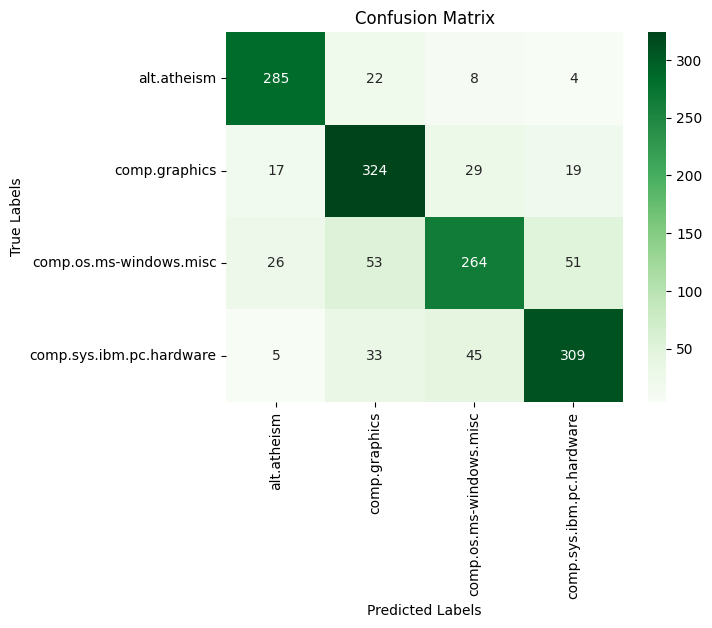

In [17]:
# extracting features
vectorizer = TfidfVectorizer(stop_words = "english")
X_train = vectorizer.fit_transform(news_train.data)
X_test = vectorizer.transform(news_test.data)

# regression
clf = RidgeClassifier(tol = 1e-2, solver = "sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred, target_names = target_names[:4]))

sns.heatmap(confusion_matrix(y_test, pred), cmap = "Greens", annot = True, fmt = "d", xticklabels = target_names[:4], yticklabels = target_names[:4])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title("Confusion Matrix")

## Using the fine tuned model
As an example, we tokenize some sample_text and run it through the model to get the logits (explained earlier, the scores we took an
argmax over to get a prediction).

In [18]:
example_text = dd['test']['text'][5]
example_text

'24bit color dpi fladbed scanner job gif tiff pcx bmp interested please write imagesyzaolcom'

In [19]:
with torch.no_grad():
  logits = model(tokenizer.encode(example_text, return_tensors="pt").to(device)).logits.cpu()
logits

tensor([[-1.6510,  2.6737, -0.7002, -0.0927]])

Use scipy.special.softmax to create probabilities

In [20]:
probs = sp.special.softmax(logits.flatten())
probs

array([0.01192147, 0.90059495, 0.0308504 , 0.05663307], dtype=float32)

and plot the probabilities of each class

<Axes: >

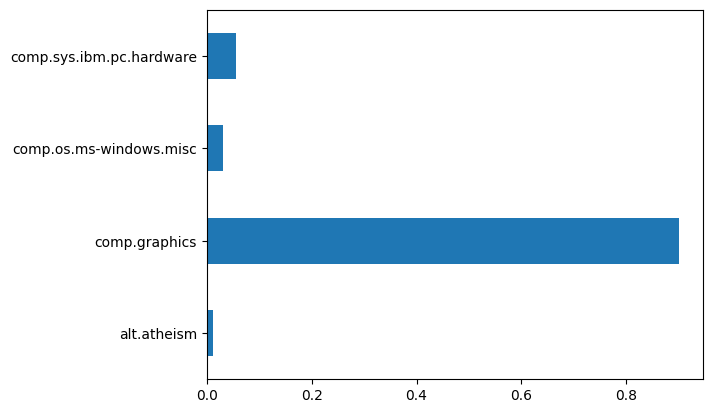

In [21]:
labels = news_train['target_names']
pd.Series(probs, index = news_train['target_names']).plot.barh()